In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns
import matplotlib.pyplot as plt
# Load the dataset
data = pd.read_csv('/content/amazon_data.csv',error_bad_lines=False)
print(data.shape)
data.head()

(19387, 7)


<ipython-input-1-9bd2d80e4597>:14: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('/content/amazon_data.csv',error_bad_lines=False)
Skipping line 1623: expected 7 fields, saw 13



,Title,Category,Sub-Category,Price,Ratings,Total Ratings,Product URL
0,Amazon Basics Universal Travel Case Organizer ...,Electronics,Computers & Accessories,15,4.6,"17,329",/AmazonBasics-Universal-Organizer-Electronics-...
1,WILSON ELECTRONICS 971117 Cellular Booster Acc...,Electronics,Computers & Accessories,12,4.5,3,/ELECTRONICS-Accessory-Connector-Electronics-A...
2,A10-16 DIRECT CONNECT CABLE OR Electronics & c...,Electronics,Computers & Accessories,NaN,5.0,2,/A10-16-CONNECT-Electronics-computer-accessori...
3,Bar Fly 4 Prime Aluminum Bicycle Accessory Mou...,Electronics,Computers & Accessories,45,4.4,102,/Bar-Fly-Aluminum-Computers-Magellan/dp/B01M66...
4,"Cherry Electronics M-5400, Accessory, Optical ...",Electronics,Computers & Accessories,NaN,5.0,13,/Cherry-Electronics-M-5400-Accessory-Connector...


In [3]:
data['Sub-Category'].value_counts()

Makeup (Face Makeup)                       360
Sports Gear (Golf)                         360
Cookware & Dining (Utensils)               360
Kitchen Appliances (Coffee Makers)         360
Haircare (Styling Products)                359
                                          ... 
Kitchen Appliances (Ovens & Stoves)        160
Kitchen Appliances (Refrigerators)          76
Cookware & Dining (Glassware)               60
Makeup (Makeup Tools & Brushes)             51
Exercise & Fitness (Sports Supplements)     48
Name: Sub-Category, Length: 65, dtype: int64

In [4]:
data.isnull().sum()

Title               0
Category            0
Sub-Category        0
Price            3902
Ratings          4932
Total Ratings    4932
Product URL         0
dtype: int64

In [5]:
# Convert columns to numeric type
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
data['Ratings'] = pd.to_numeric(data['Ratings'], errors='coerce')
data['Total Ratings'] = pd.to_numeric(data['Total Ratings'], errors='coerce')

# Calculate the mean of each column
price_mean = data['Price'].mean()
ratings_mean = data['Ratings'].mean()
total_ratings_mean = data['Total Ratings'].mean()

# Fill NaN values with the mean of each column
data['Price'].fillna(price_mean, inplace=True)
data['Ratings'].fillna(ratings_mean, inplace=True)
data['Total Ratings'].fillna(total_ratings_mean, inplace=True)

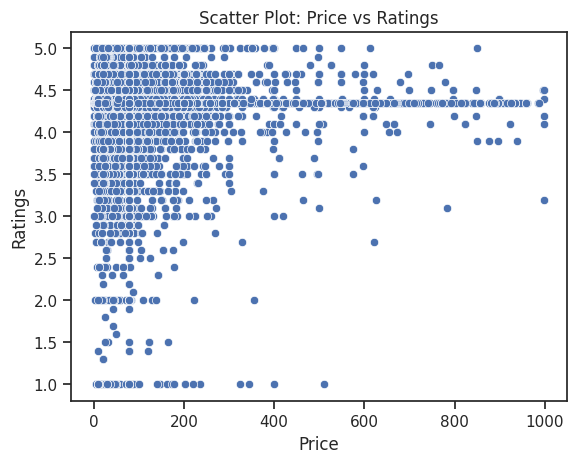

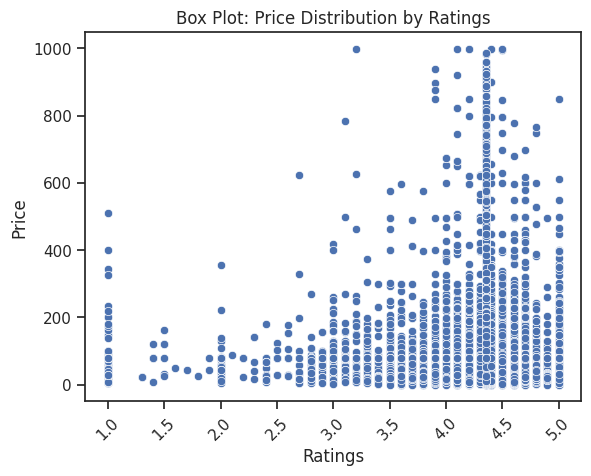

In [6]:
# Set the style of seaborn
sns.set(style="ticks")

# Create a scatter plot with Price on the x-axis, Ratings on the y-axis, and hue as Category
sns.scatterplot(data=data, x="Price", y="Ratings")
plt.title("Scatter Plot: Price vs Ratings")
plt.show()


# Create a box plot to compare the Price distribution across Categories
sns.scatterplot(data=data, x="Ratings", y="Price")
plt.title("Box Plot: Price Distribution by Ratings")
plt.xticks(rotation=45)
plt.show()

In [7]:
print(data['Title'].unique())

['Amazon Basics Universal Travel Case Organizer for Small Electronics and Accessories, Black'
 'WILSON ELECTRONICS 971117 Cellular Booster Accessory (N Female/N Female Barrel Connector) Electronics Computers Accessories'
 'A10-16 DIRECT CONNECT CABLE OR Electronics & computer accessories' ...
 'N/A Fitness Trainning Yoga Short Pants Women Gym Shorts High Waist Push Up Cycling Sport Leggings Phone Pockets (Color : Gray, Size : Small)'
 "DKNY Women's Bike Color Block High Waist Short"
 'O2 Rainwear Original Cycling Jacket']


In [8]:
# Combine relevant columns into a single feature
data['Features'] = data['Title'] + ' ' + data['Category'] + ' ' + data['Sub-Category']

# Define the feature transformation steps
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english'), 'Features'),
        ('numeric', StandardScaler(), ['Price', 'Ratings', 'Total Ratings']),
        ('categorical', OneHotEncoder(), ['Category', 'Sub-Category'])
    ]
)

# Transform the features
feature_matrix = preprocessor.fit_transform(data)

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(feature_matrix, feature_matrix)


In [9]:
# Clustering using DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(feature_matrix)

# Clustering using K-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(feature_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [10]:
# Function to get recommendations based on the title and cluster label
def get_recommendations(title, cluster_label, cosine_sim, n_recommendations=5):
    # Get the indices of products in the same cluster
    cluster_indices = [i for i, label in enumerate(dbscan.labels_) if label == cluster_label]

    # Get the index of the product that matches the title
    indices = pd.Series(data.index, index=data['Title']).drop_duplicates()
    idx = indices[title]

    # Get the pairwise similarity scores within the cluster
    sim_scores = [(i, cosine_sim[idx][i]) for i in cluster_indices]

    # Sort the products based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top N most similar products
    sim_scores = sim_scores[:n_recommendations]
    product_indices = [i[0] for i in sim_scores]

    return data[['Title', 'Category', 'Sub-Category', 'Price', 'Ratings', 'Total Ratings']].iloc[product_indices]

# Get recommendations for a specific product within the DBSCAN clusters
title = 'Amazon Basics Universal Travel Case Organizer for Small Electronics and Accessories, Black'
cluster_label = dbscan.labels_[data[data['Title'] == title].index[0]]
recommendations_dbscan = get_recommendations(title, cluster_label, cosine_sim)
print("Recommendations using DBSCAN:")
print(recommendations_dbscan)

# Get recommendations for a specific product within the K-means clusters
cluster_label = kmeans.labels_[data[data['Title'] == title].index[0]]
recommendations_kmeans = get_recommendations(title, cluster_label, cosine_sim)
print("Recommendations using K-means:")
print(recommendations_kmeans)

Recommendations using DBSCAN:
                                                 Title     Category  \
0    Amazon Basics Universal Travel Case Organizer ...  Electronics   
282  Amazon Basics External Hard Drive Portable Car...  Electronics   
237  Pink Camera Electronic Organizer, Shockproof C...  Electronics   
301  Star Simple Electronic Organizer, Shockproof C...  Electronics   
279  Video Disc Electronic Organizer, Shockproof Ca...  Electronics   

                Sub-Category  Price   Ratings  Total Ratings  
0    Computers & Accessories   15.0  4.600000     171.541304  
282  Computers & Accessories    9.0  4.800000     171.541304  
237  Computers & Accessories   26.0  4.350785     171.541304  
301  Computers & Accessories   26.0  4.350785     171.541304  
279  Computers & Accessories   26.0  4.350785     171.541304  
Recommendations using K-means:
                                                 Title     Category  \
472  OtterBox Alpha Glass Series Screen Protector f...  Electro

In [12]:
len(cosine_sim)

19387

In [13]:
import joblib
joblib.dump(dbscan, 'model.joblib')
joblib.dump(feature_matrix, 'feature_matrix.joblib')

['feature_matrix.joblib']